<a href="https://colab.research.google.com/github/claredavies/DataScienceCoursework/blob/master/DataScience3Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import os
import tweepy as tw
import pandas as pd
import sys 
import tweepy
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
from tweepy import Stream
import time
# Authenticate to Twitter
auth = tw.OAuthHandler("iy5oGHP6q1b6Zg14XpVnGct9z", 
    "Y3iHHViLz7XVWw0sSjiHaRWGZVeSnSmjugmtT8BwJw0R0ZK9X7")
auth.set_access_token("1450047668554698752-ogdyTTSKpSEwBMOVR2Teuu7uohrp6z", 
    "trIEAFunzkj70ILmhaJ8jFgoIOQvF1rIy9zDUJb325TGm")

api = tw.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [50]:
import datetime

# The search term you want to find
query = "#anxiety -filter:retweets"

tod = datetime.datetime.now()
d = datetime.timedelta(days = 7)
limit = tod - d
print(limit)
print(tod)
since_date = '2021-10-13'
until_date = '2021-10-20'

tweets = tw.Cursor(api.search,q=query,count = 100,lang="en",since=since_date, until=until_date, tweet_mode='extended').items()

# store the API responses in a list
tweets_copy = []

for tweet in tweets:
    tweets_copy.append(tweet)
    
print("Total Tweets fetched:", len(tweets_copy))

2021-10-13 13:27:58.172107
2021-10-20 13:27:58.172107
Total Tweets fetched: 5759


In [52]:
# intialize the dataframe
tweets_df = pd.DataFrame()

# populate the dataframe
for tweet in tweets_copy:
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
            # for text need to call api again with tweet id
        text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    except:
        pass
    tweets_df = tweets_df.append(pd.DataFrame({'user_name': tweet.user.name, 
                                               'user_location': tweet.user.location,
                                               'user_description': tweet.user.description,
                                               'day': tweet.created_at.day,
                                               'hour': tweet.created_at.hour,
                                               'text': text, 
                                               'hashtags': [hashtags if hashtags else None],
                                               'source': tweet.source}))
    tweets_df = tweets_df.reset_index(drop=True)

# show the dataframe
tweets_df.head(50)

,user_name,user_location,user_description,day,hour,text,hashtags,source
0,Evan Kirste at #HLTH2021,#RemoteWork #Boston,Need to scale your reach & engagement on #soci...,19,23,The Power of Music #mentalhealth #MentalHealth...,"[mentalhealth, MentalHealthMatters, anxiety, A...",Twitter for iPhone
1,iHire,"Frederick, MD & Angola, IN",Looking for a job? We continuously post the la...,19,23,New Job Opening: Licensed Therapist (#Scottsda...,"[Scottsdale, job, BehavioralTherapy, Behaviora...",Employer Tweet Updates
2,Online Mindfulness Therapy,"Boulder CO, USA",Peter Strong - Psychotherapist specializing in...,19,23,Online Therapy for Panic Attacks https://t.co/...,"[anxiety, anxietytreatment, anxietytherapy, an...",Buffer
3,blckborne,"London, England",Will U Be My Echo?,19,23,Today I turned 23 and I found 1 white hair on ...,"[anxiety, CancelStudentDebt, ADHD]",Twitter for Android
4,iHire,"Frederick, MD & Angola, IN",Looking for a job? We continuously post the la...,19,23,"New Opportunity: Licensed Therapist (#Tempe, A...","[Tempe, job, BehavioralTherapy, BehavioralHeal...",Employer Tweet Updates
5,Jaycee_cos,,I'm just here...\n\nhttps://t.co/PJnek6R9L6,19,23,And this is why I don't make relatable content...,"[exrelationship, anxiety, MentalHealthMatters,...",Twitter for Android
6,Karina,"Brisbane, Queensland","Wife, Mum, part-time PhD student (Blockchain),...",19,23,I have anxiety. This is triggered when I have ...,"[dv, trauma, anxiety]",Twitter for iPhone
7,Magdalena Kaczmarczyk,"Tienen, België","T-shirts by Magdalena Kaczmarczyk. Exclusive, ...",19,23,I am feeling fucking lonely #intags #loneline...,"[intags, loneliness, looser, naive, to, failur...",Twitter for Android
8,On the Borderline between Emotional 😭 & Stable 😊,Check out my Website 🌻😊👇🏻,The 💯% honest views of a Guy from the UK 🇬🇧 wh...,19,23,Thank you so much to My Star Wars Life who is ...,"[BPD, EUPD, OCD, Anxiety, Depression, MentalHe...",IFTTT
9,CareersInGovernment,"Los Angeles, CA",The nation's largest State and Local Governmen...,19,23,Accepting That You'll Never Finish Your To-Do ...,"[list, accepting, anxiety]",drumup.io


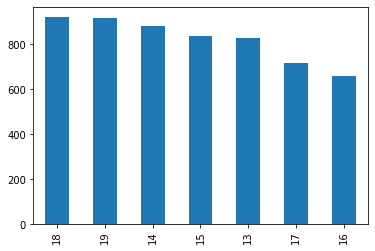

In [59]:
plot = tweets_df['day'].value_counts(sort=True).plot.bar()
